# **Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer**

> Transfer learning, where a model is first pre-trained on a data-rich task before being fine-tuned on a downstream task, has emerged as a powerful technique in natural language processing (NLP). The effectiveness of transfer learning has given rise to a diversity of approaches, methodology, and practice. In this paper, we explore the landscape of transfer learning techniques for NLP by introducing a unified framework that converts all text-based language problems into a text-to-text format. Our systematic study compares pre-training objectives, architectures, unlabeled data sets, transfer approaches, and other factors on dozens of language understanding tasks. By combining the insights from our exploration with scale and our new “Colossal Clean Crawled Corpus”, we achieve state-of-the-art results on many benchmarks covering summarization, question answering, text classification, and more. To facilitate future work on transfer learning for NLP, we release our data set, pre-trained models, and code

**Important Note:** The goal of this project is to provide a deep understanding of the GPT architecture and its inner workings. So, it's only for educational purposes.

## **Overview**

The T5 language model, short for "Text-to-Text Transfer Transformer", is a type of deep learning model designed for a wide range of natural language processing (NLP) tasks. It was developed by researchers at Google and introduced in a paper titled "Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer" in 2019. The unique aspect of T5 is its text-to-text framework, where every NLP task is reframed as a text generation problem. This means inputs are always text strings, and the model is trained to produce outputs in the form of text strings as well.

T5 covers a variety of tasks including translation, summarization, question answering, and classification, by simply changing the format of the input text. For example, to perform translation from English to French, the input could be prepended with "Translate English to French:", followed by the text to be translated. For summarization, the input could start with "Summarize:", followed by the text to summarize.

The T5 model was pre-trained on a large corpus called the "Colossal Clean Crawled Corpus" (C4), which is a cleaned version of Common Crawl data. The pre-training involved a denoising objective similar to the one used by BERT (another prominent NLP model), but with a focus on generating the entire input sequence rather than predicting individual masked words.

T5 comes in various sizes such as small, base and large, with the number of parameters ranging from hundreds of millions to billions, allowing it to be adaptable for different computational needs and tasks. Its architecture is based on the Transformer model, which relies on self-attention mechanisms to process sequences of text.

**Tips:**
Before you complete this demo, I assume that you have a good understanding of the transformer architecture. If not, I advise you to start with:
* (Required) [Transformer-from-Scratch-with-Tensorflow](https://github.com/AliHaiderAhmad001/Transformer-from-Scratch-with-Tensorflow).
* (Optional) [BERT-from-Scratch-with-PyTorch](https://github.com/AliHaiderAhmad001/BERT-from-Scratch-with-PyTorch).
* (Optional) [GPT-from-Scratch-with-Tensorflow](https://github.com/AliHaiderAhmad001/GPT-from-Scratch-with-Tensorflow).

I'm also assuming you've read [the paper](https://arxiv.org/abs/1910.10683) or at least the part related to the Training Objective and Model.

This will make life clearer and easier for you.


**Some considerations related to the differences from orginal Transformer architecture**

**Note:** We must know that the transformer model is a model that was created primarily for the task of translation and not as a language model or learning transfer model. So here we are not comparing them, as they are two different things, but we are talking about the structure of the model, which is comparable.

Differences in the implementation of the Transformer architecture compared to the original proposal by Vaswani et al. (2017). Here are the identified differences:

1. **Layer Normalization.** The original Transformer proposed by Vaswani et al. (2017) uses a form of layer normalization that includes both rescaling and additive bias. However, in the described implementation, a simplified version of layer normalization is employed, where only rescaling is applied, and no additive bias is used. Additionally, the layer normalization is placed outside the residual path.

2. **Position Embedding Scheme.** While the original Transformer used sinusoidal position signals or learned position embeddings, the described implementation uses a different approach. It employs relative position embeddings instead of fixed embeddings for each position. The relative position embeddings produce a different learned embedding based on the offset between the "key" and "query" in the self-attention mechanism. This scheme involves adding a scalar to the corresponding logit used for computing attention weights. I'm not going to explain it, just explain it and talk about how to implement it [here](https://github.com/AliHaiderAhmad001/T5-Relative-Position).
3. **Training Objective.** A new training objective derived from Bert's MLM is used (This point relates to the difference between it and other language models and learning transfer models whose structure is based on the transformer model.).
4. Other minor differences, such as weights are shared between the embedding layer and the final output layer.

## **Dataset & Download**

The original model uses a special data set called [C4](https://www.tensorflow.org/datasets/catalog/c4). It's so huge we can't handle it here. So as usual we will grab a simple dataset like IMDB and apply the general approach to it.

In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/projects/T5-PyTorch-DeepDive-Building-and-Exploring-Text-to-Text-Transfer-Transformer-from-Scratch/datasets'
#!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
#!tar -xf aclImdb_v1.tar.gz

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/projects/T5-PyTorch-DeepDive-Building-and-Exploring-Text-to-Text-Transfer-Transformer-from-Scratch/datasets'
/content


## **Setup**

In [1]:
%cd '/content/drive/MyDrive/Colab Notebooks/projects/T5-PyTorch-DeepDive-Building-and-Exploring-Text-to-Text-Transfer-Transformer-from-Scratch/'

/content/drive/MyDrive/Colab Notebooks/projects/T5-PyTorch-DeepDive-Building-and-Exploring-Text-to-Text-Transfer-Transformer-from-Scratch


In [2]:
!pip install transformers
# pip install sentencepiece
#!pip install tqdm

## **Imports**

In [3]:
import os
import re
import torch
import math
import torch.nn as nn
import numpy as np
import random as rd
from math import ceil
from tqdm import tqdm
from torch import Tensor
import torch.optim as optim
from torch.optim import Adam
from torch.nn import functional as F
from transformers import T5TokenizerFast
from torch.optim.optimizer import Optimizer
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict, Union, Any, Callable, Iterable

https://colabdoge.medium.com/understanding-sentencepiece-under-standing-sentence-piece-ac8da59f6b08

##**Data preprocessing**

### Create Text.data

Our dataset consists of two folders train and test, each of which includes two subfolders named pos and neg containing a specified number of text documents representing movie reviews. This does not matter to us, what matters to us is that they are text documents that we can train the model on. I will collect these texts into one file named "text_data.txt".


In [4]:
def read_file(f_path):
    """Reads and returns the content of a file."""
    try:
        with open(f_path, "r", encoding="utf-8") as file:  # Added encoding
            doc = file.read().strip()
    except Exception as e:  # Added error handling
        print(f"Error reading {f_path}: {e}")
        doc = ""
    return doc

def get_filenames(data_dir):
    filenames = []
    for root, dirs, files in os.walk(data_dir):
        if os.path.basename(root) in ['neg', 'pos'] and os.path.basename(os.path.dirname(root)) in ['train', 'test']:
            for file in files:
                filepath = os.path.join(root, file)
                filenames.append(filepath)
    return filenames

def create_data_file(data_dir, f_target='dataset/text_data.txt'):
    """Combines text from all files in a directory into a single file."""
    files = get_filenames(data_dir)
    # Ensure the target directory exists
    os.makedirs(os.path.dirname(f_target), exist_ok=True)  # Ensure target directory exists
    with open(f_target, "w", encoding="utf-8") as f:  # Added encoding
        for f_path in tqdm(files, desc="Processing files"):
            doc = read_file(f_path)
            f.write(doc + "\n")

#create_data_file('dataset/aclImdb')

### Create Training File

We will now create a function to perform the corruption task (or masking).

Given the sentence:

> Thank you for inviting me to your party last week.

**Input**: `Thank you <X> me to your party <Y> week`
**Target**: `<X> for inviting <Y> last <Z>`

> We process the sentence `Thank you for inviting me to your party last week.` The words `for`, `inviting` and `last` are randomly chosen for corruption. Each consecutive span of corrupted tokens is replaced by a sentinel token (shown as `<X>` and `<Y>`) that is unique over the example. Since `for` and `inviting` occur consecutively, they are replaced by a single sentinel `<X>`. The output sequence then consists of the dropped-out spans, delimited by the sentinel tokens used to replace them in the input plus a final sentinel token `<Z>`.

In [5]:
def mask_sentence(tokens: List[str], prop: float) -> Tuple[List[str], List[str]]:
    def get_next(index, li):
        return li[index] if index < len(li) else -1

    def get_sentinel():
        nonlocal sentinel_count
        sentinel_token = f"<extra_id_{sentinel_count}>"
        sentinel_count += 1
        return sentinel_token

    # Calculate the number of tokens to mask, and randomly select indices for masking
    num_masked = ceil(prop * len(tokens))
    masked_indices = sorted(rd.sample(range(len(tokens)), num_masked))
    #print(masked_indices)
    input_sequence = tokens.copy()
    target_sequence = []
    sentinel_count = 0

    i = 0
    while i < len(masked_indices):
        idx = masked_indices[i]
        sentinel_token = get_sentinel()

        # For the first token in a consecutive sequence, replace with sentinel
        if i == 0 or masked_indices[i-1] != idx - 1:
            input_sequence[idx] = sentinel_token
            target_sequence.append(sentinel_token)

        target_sequence.append(tokens[idx])

        # If the next index is consecutive, we remove it from input_sequence
        # by marking it as None; we'll filter these out later
        next_idx = get_next(i+1, masked_indices)
        while idx + 1 == next_idx:
            i += 1
            idx = masked_indices[i]
            input_sequence[idx] = None  # Mark for removal
            target_sequence.append(tokens[idx])
            next_idx = get_next(i+1, masked_indices)

        i += 1

    # Remove marked indices (None) from input_sequence
    input_sequence = [token for token in input_sequence if token is not None]
    return (input_sequence, target_sequence)

In [6]:
# Test
tokens = ["Younes", "and", "Lukasz", "were", "working", "together", "in", "the", "lab", "yesterday", "after", "lunch."]
input_sequence, target_sequence = mask_sentence(tokens, prop=0.50)

print("Input Sequence:", " ".join(tokens))
print("Input Sequence:", " ".join(input_sequence))
print("Target Sequence:", " ".join(target_sequence))

Input Sequence: Younes and Lukasz were working together in the lab yesterday after lunch.
Input Sequence: Younes and <extra_id_0> working <extra_id_1> in the <extra_id_2> yesterday <extra_id_3>
Target Sequence: <extra_id_0> Lukasz were <extra_id_1> together <extra_id_2> lab <extra_id_3> after lunch.


We now create the `preprocessing` function that processes the texts and stores them in a file called "train.txt". The processing process includes tokenizing the texts, the process of corruption, and creating the inputs and outputs of the texts, but this stage will not include converting the tokens into identifiers. This file we will use for the training process.

In [7]:
def custom_std(line, lower_case=True):
    """ Remove HTML line-break tags and lowercase the sentence."""
    line = re.sub("<br />", " ", line).strip()
    if lower_case:
        line = line.lower()
    return line

def preprocessing(f_path, f_target, tokenizer_path='t5-base', prop = 0.15, max_words=768, extra_ids = 115, lower_case = True):
    tokenizer = T5TokenizerFast.from_pretrained(tokenizer_path, extra_ids = extra_ids+1)
    with open(f_target, 'w') as outfile:
          with open(f_path, 'r') as infile:
              for line in infile:
                    line = custom_std(line, lower_case = lower_case)
                    tokens = tokenizer.tokenize(line) # list[str]
                    # Ensure the sentence is within the max_words limit
                    tokens = tokens[:max_words]
                    encoder_in, target_str = mask_sentence(tokens, prop)
                    decoder_in = target_str.copy()
                    decoder_out = target_str.copy()[1:]
                    decoder_out.append(f"<extra_id_{extra_ids+1}>")
                    outfile.write(" ".join(encoder_in) +'\n' + " ".join(decoder_in) + '\n' + " ".join(decoder_out) + '\n\n')

In [8]:
# Test
#preprocessing('dataset/dummy_data/sample_test.txt', 'dataset/dummy_data/out.txt')

In [9]:
#preprocessing('dataset/text_data.txt', 'dataset/train.txt')

## **Config**

In [4]:
class Config:
    """
    Configuration class for your model and training.

    Args:
        prop (float): Proportion of tokens to mask in each sentence. Default is 0.15.
        tokenizer_path (str): Path to the tokenizer. Default is "bert-base-uncased".
        max_token_len (int): Maximum sequence length. Default is 128.
        data_dir (str): Directory containing the data file.

        # Embeddings params
        hidden_size (int): Size of the hidden layers. Default is 768.
        vocab_size (int): Size of the vocabulary. Default is 30522.
        hidden_dropout_prob (float): Dropout probability for hidden layers. Default is 0.1.

        # Attention params
        num_heads (int): Number of attention heads. Default is 8.

        # model params
        num_blocks (int): Number of blocks in the BERT model. Default is 12.

        # Optimizer params
        n_warmup_steps (int): Number of warmup steps for the optimizer. Default is 10000.

        # Trainer params
        cuda_devices (list): List of CUDA devices. Default is None.
        with_cuda (bool): Flag to use CUDA. Default is True.
        log_freq (int): Logging frequency. Default is 10.
        batch_size (int): Batch size for training. Default is 64.
        save_path (str): Path to save model checkpoints. Default is 'tmp/checkpoints'.

        # Run the model params
        seed (int): Random seed for reproducibility. Default is 0.
        test_dataset (str): Path to the test dataset or None. Default is None.
        epochs (int): Number of training epochs. Default is 1.
    """

    def __init__(self, prop=0.15, tokenizer_path="t5-base", max_token_len=768, data_dir="dataset/train.txt",
                 hidden_size=768, bidirectional = True, num_buckets = 32, max_distance = 128,
                 vocab_size=32000, hidden_dropout_prob=0.1, num_heads=8, num_blocks=12,
                 n_warmup_steps=10000, cuda_devices=None, with_cuda=True, log_freq=10, batch_size=64, save_path='tmp/checkpoints',
                 seed=0, test_dataset=None, epochs=1):

        # Dataset params
        self.prop = prop
        self.tokenizer_path = tokenizer_path
        self.max_token_len = max_token_len
        self.data_dir = data_dir

        # Relative pos params
        self.bidirectional = bidirectional
        self.num_buckets = num_buckets
        self.max_distance = max_distance

        # Embeddings params
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size + 100 # We add 100 for the number of sentinals we use
        self.hidden_dropout_prob = hidden_dropout_prob

        # Attention params
        self.num_heads = num_heads

        # BERT model params
        self.num_blocks = num_blocks

        # Optimizer params
        self.n_warmup_steps = n_warmup_steps

        # Trainer params
        self.cuda_devices = cuda_devices
        self.with_cuda = with_cuda
        self.log_freq = log_freq
        self.batch_size = batch_size
        self.save_path = save_path

        # Run the model params
        self.seed = seed
        self.test_dataset = test_dataset
        self.epochs = epochs


## **DataLoader**

This dataset class is a starting point and might need adjustments based on specific task requirements, such as handling different data formats or more complex preprocessing steps.

- **Efficiency**: For large datasets, consider loading and processing data in more memory-efficient ways, especially when dealing with very large files.
  
- **Error Handling**: Consider adding error handling for file reading and processing to ensure robustness, especially with varied or inconsistent data formats.

- **Batch Processing**: When used with `DataLoader`, this dataset setup allows for efficient batch processing of data, including automatic batching, shuffling, and parallel data loading.


In [5]:
from torch.utils.data import Dataset
from transformers import T5TokenizerFast

class CustomTextDataset(Dataset):
    """
    A PyTorch Dataset class for handling custom text data.

    Args:
        filename (str): Path to the file containing the text data.
        tokenizer (str or transformers.PreTrainedTokenizerFast, optional): Pre-trained tokenizer or tokenizer name to use for tokenization. Defaults to 't5-base'.
        max_token_len (int, optional): Maximum length of tokens for encoding. Defaults to 512.
    """
    def __init__(self, filename, tokenizer='t5-base', max_token_len=512):
        self.tokenizer = T5TokenizerFast.from_pretrained(tokenizer)
        self.items = []
        self.max_token_len = max_token_len

        with open(filename, 'r', encoding='utf-8') as file:
            while True:
                encoder_in = file.readline().strip()
                if not encoder_in:
                    break
                decoder_in = file.readline().strip()
                decoder_out = file.readline().strip()
                self.items.append((encoder_in, decoder_in, decoder_out))

                _ = file.readline()

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.items)

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the encoder and decoder inputs, attention mask, and labels.
        """
        encoder_in, decoder_in, decoder_out = self.items[idx]

        encoder_ids = self.tokenizer(
            encoder_in,
            max_length=self.max_token_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        target_ids = self.tokenizer(
            decoder_in,
            max_length=self.max_token_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        ).input_ids
        labels = self.tokenizer(
            decoder_out,
            max_length=self.max_token_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        ).input_ids

        return {
            "encoder_ids": encoder_ids["input_ids"].squeeze(),
            "attention_mask": encoder_ids["attention_mask"].squeeze(),
            "decoder_ids": target_ids.squeeze(),
            "labels": labels.squeeze()
        }


In [6]:
# Test
dataset_path = "dataset/dummy_data/out.txt"
custom_dataset = CustomTextDataset(filename=dataset_path, max_token_len=10)

data_loader = DataLoader(custom_dataset, batch_size=2)

for batch in data_loader:
    encoder_ids = batch['encoder_ids']
    decoder_ids = batch['decoder_ids']
    labels = batch['labels']
    att_mask = batch['attention_mask']
    print(encoder_ids.shape, decoder_ids.shape, labels.shape)
    print("------------")
    assert encoder_ids.shape == labels.shape
    print(encoder_ids)
    print(decoder_ids)
    print(labels)
    print(att_mask)
    print('----------------------------')
    break

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


torch.Size([2, 10]) torch.Size([2, 10]) torch.Size([2, 10])
------------
tensor([[    3,  5627, 32099,     3,     9,  8434,  2870,     3,    49,     1],
        [  168,     3,     6,    34,     3,    31,     3,     7, 32099,     1]])
tensor([[32099,    38, 32098,    11, 32097,     3,     6, 32096,     3,     1],
        [32099,  1346,    12, 32098,     3,    55,     1,     0,     0,     0]])
tensor([[   38, 32098,    11, 32097,     3,     6, 32096,     3,     5,     1],
        [ 1346,    12, 32098,     3,    55,     3,     2, 25666,   834,     1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
----------------------------


## **T5 Bulding Blocks**

Most of the components are not much different from the original transformer model that we explained previously. We have already mentioned the basic changes.

### RelativePositionBias

I've explained it [here](https://github.com/AliHaiderAhmad001/T5-Relative-Position).

In [7]:
import torch
import torch.nn as nn

class RelativePositionBias(nn.Module):
    """
    Translate relative position to a bucket number for relative attention.

    The relative position is defined as memory_position - query_position, i.e.
    the distance in tokens from the attending position to the attended-to
    position. If bidirectional=False, then positive relative positions are
    invalid.

    We use smaller buckets for small absolute relative_position and larger buckets
    for larger absolute relative_positions. All relative positions >=max_distance
    map to the same bucket. All relative positions <=-max_distance map to the
    same bucket. This should allow for more graceful generalization to longer
    sequences than the model has been trained on.

    Args:
        bidirectional (bool): Whether the attention is bidirectional.
        num_buckets (int): Number of buckets.
        max_distance (int): Maximum distance for relative positions.
        num_heads (int): Number of attention heads.

    # REFRANCE: https://github.com/tensorflow/mesh/blob/0cb87fe07da627bf0b7e60475d59f95ed6b5be3d/mesh_tensorflow/transformer/transformer_layers.py#L593
    """
    def __init__(self, config):
        super(RelativePositionBias, self).__init__()
        self.bidirectional = config.bidirectional
        self.num_buckets = config.num_buckets
        self.max_distance = config.max_distance
        self.num_heads = config.num_heads
        self.relative_attention_bias = nn.Embedding(self.num_buckets, self.num_heads)

    @staticmethod
    def _relative_position_bucket(relative_position, bidirectional=True, num_buckets=32, max_distance=128):
        """
        Translate relative position to a bucket number.

        Args:
            relative_position (torch.Tensor): Relative position tensor.
            bidirectional (bool): Whether the attention is bidirectional.
            num_buckets (int): Number of buckets.
            max_distance (int): Maximum distance for relative positions.

        Returns:
            torch.Tensor: Bucket number tensor.
        """
        ret = 0 * relative_position  # Initialized to zero to handle both positive and negative positions
        if bidirectional:
            num_buckets //= 2  # Halve the buckets for bidirectional case
            ret += (relative_position < 0).long() * num_buckets
            relative_position = relative_position.abs()
        max_exact = num_buckets // 2
        is_small = relative_position < max_exact

        # Compute val_if_large with safe clamping within [0, num_buckets - 1]
        val_if_large = max_exact + (
            torch.log(relative_position.float() / max_exact) /
            torch.log(torch.tensor(max_distance / max_exact, dtype=torch.float)) *
            (num_buckets - max_exact)
        ).long()
        val_if_large = torch.minimum(val_if_large, torch.tensor(num_buckets - 1, dtype=torch.long))

        # Combine small and large relative positions
        ret += torch.where(is_small, relative_position, val_if_large)

        return ret

    def compute_bias(self, qlen, klen):
        """
        Compute binned relative position bias.

        Args:
            qlen (int): Length of the query sequence.
            klen (int): Length of the key sequence.

        Returns:
            torch.Tensor: Relative position bias tensor.
        """
        device = self.relative_attention_bias.weight.device
        context_position = torch.arange(qlen, dtype=torch.long, device=device)[:, None]
        memory_position = torch.arange(klen, dtype=torch.long, device=device)[None, :]
        relative_position = memory_position - context_position

        rp_bucket = self._relative_position_bucket(
            relative_position,
            bidirectional=self.bidirectional,
            num_buckets=self.num_buckets,
            max_distance=self.max_distance
        )

        values = self.relative_attention_bias(rp_bucket)
        values = values.permute([2, 0, 1]).unsqueeze(0)

        return values


    def forward(self, qlen, klen):
        """
        Forward pass.

        Args:
            qlen (int): Length of the query sequence.
            klen (int): Length of the key sequence.

        Returns:
            torch.Tensor: Relative position bias tensor.
        """

        return self.compute_bias(qlen, klen)


In [8]:
class Configx:
    bidirectional = True
    num_buckets = 32
    max_distance = 128
    num_heads = 8

# Example usage
config = Configx()
relative_position_bias_module = RelativePositionBias(config)
qlen, klen = 768, 768
bias_tensor = relative_position_bias_module.forward(qlen, klen)
print(bias_tensor.shape)
print(bias_tensor)

torch.Size([1, 8, 768, 768])
tensor([[[[ 0.7986,  0.9558, -1.2128,  ..., -0.8910, -0.8910, -0.8910],
          [ 1.4734,  0.7986,  0.9558,  ..., -0.8910, -0.8910, -0.8910],
          [ 1.0884,  1.4734,  0.7986,  ..., -0.8910, -0.8910, -0.8910],
          ...,
          [-0.0962, -0.0962, -0.0962,  ...,  0.7986,  0.9558, -1.2128],
          [-0.0962, -0.0962, -0.0962,  ...,  1.4734,  0.7986,  0.9558],
          [-0.0962, -0.0962, -0.0962,  ...,  1.0884,  1.4734,  0.7986]],

         [[-1.0047, -1.9855, -0.9020,  ..., -0.4914, -0.4914, -0.4914],
          [ 0.6632, -1.0047, -1.9855,  ..., -0.4914, -0.4914, -0.4914],
          [-1.8598,  0.6632, -1.0047,  ..., -0.4914, -0.4914, -0.4914],
          ...,
          [ 0.1859,  0.1859,  0.1859,  ..., -1.0047, -1.9855, -0.9020],
          [ 0.1859,  0.1859,  0.1859,  ...,  0.6632, -1.0047, -1.9855],
          [ 0.1859,  0.1859,  0.1859,  ..., -1.8598,  0.6632, -1.0047]],

         [[ 0.6221, -0.5309,  0.5113,  ...,  0.5431,  0.5431,  0.5431],
 

### Embeddings layer

In [9]:
#import torch
#import torch.nn as nn
#from relative_position_bias import RelativePositionBias

class Embeddings(nn.Module):
    """
    The Embeddings class is a crucial component of transformer-based models, responsible for converting input token IDs into dense vector representations. These embeddings are the first step in processing input data, transforming discrete token IDs into continuous vectors that can encapsulate semantic information. This class not only performs token embedding lookup but also applies layer normalization and dropout for regularization.

    The embedding vectors produced by this class serve as the input to subsequent layers of the model, facilitating the learning of token-specific features in the context of the task at hand, whether it be language understanding, translation, or another natural language processing (NLP) application.

    Attributes:
        hidden_size (int): The size of the embedding vectors. This is also the size of the hidden layers throughout the model.
        vocab_size (int): The size of the vocabulary, determining the number of unique token embeddings the layer can produce.
        hidden_dropout_prob (float): The dropout probability, used to randomly zero elements of the embedding vectors with this probability to prevent overfitting.
        token_embeddings (nn.Embedding): The PyTorch embedding layer that maps token IDs to embedding vectors.
        dropout (nn.Dropout): The dropout layer applied to the embedding vectors.
        norm (nn.LayerNorm): The layer normalization applied to the embedding vectors.

    Methods:
        forward(input_ids: torch.Tensor) -> torch.Tensor
            Performs the embedding lookup, followed by layer normalization and dropout, to produce the final embedding vectors for the input tokens.

    Args:
        config (object): A configuration object containing the attributes necessary to initialize the embedding layer. These attributes include:
            - hidden_size: The dimensionality of the embedding vectors and the model's hidden layers.
            - vocab_size: The total size of the vocabulary.
            - hidden_dropout_prob: The dropout probability for regularization.
    """
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.vocab_size = config.vocab_size
        self.hidden_dropout_prob = config.hidden_dropout_prob

        # Initialize the embedding layer, dropout, and layer normalization
        self.token_embeddings = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.hidden_size)
        self.dropout = nn.Dropout(self.hidden_dropout_prob)
        self.norm = nn.LayerNorm(self.hidden_size, eps=1e-6)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        """
        Processes input token IDs through the embedding layer, followed by layer normalization and dropout.

        Args:
            input_ids (torch.Tensor): A tensor containing a batch of input token IDs.

        Returns:
            torch.Tensor: The resulting tensor after applying embeddings, layer normalization, and dropout. This tensor is ready to be fed into subsequent layers of the model.
        """
        x = self.token_embeddings(input_ids)
        x = self.norm(x)
        x = self.dropout(x)
        return x

### Attination Head

In [10]:
#import torch
#import torch.nn as nn
#import torch.nn.functional as F

class AttentionHead(nn.Module):
    """
    Relation-aware attention head implementation.

    Args:
        hidden_size (int): Hidden size for the model (embedding dimension).
        head_dim (int): Dimensionality of the attention head.

    Attributes:
        query_weights (nn.Linear): Linear layer for query projection.
        key_weights (nn.Linear): Linear layer for key projection.
        value_weights (nn.Linear): Linear layer for value projection.
    """

    def __init__(self, hidden_size, head_dim, hidden_dropout_prob=0.1):
        """
        Initializes the AttentionHead.

        Args:
            hidden_size (int): Hidden size for the model (embedding dimension).
            head_dim (int): Dimensionality of the attention head.
            hidden_dropout_prob(float)
        """
        super().__init__()
        self.head_dim = head_dim
        self.query_weights: nn.Linear = nn.Linear(hidden_size, head_dim)
        self.key_weights: nn.Linear = nn.Linear(hidden_size, head_dim)
        self.value_weights: nn.Linear = nn.Linear(hidden_size, head_dim)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor,
                 relative_biases:torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        Applies attention mechanism to the input query, key, and value tensors.

        Args:
            query (torch.Tensor): Query tensor.
            key (torch.Tensor): Key tensor.
            value (torch.Tensor): Value tensor.
            mask (torch.Tensor): Optional mask tensor.

        Returns:
            torch.Tensor: Updated value embeddings after applying attention mechanism.
        """
        query: torch.Tensor = self.query_weights(query)
        key: torch.Tensor = self.key_weights(key)
        value: torch.Tensor = self.value_weights(value)

        att_scores: torch.Tensor = (torch.matmul(query, key.transpose(1, 2)) + relative_biases) / self.head_dim ** 0.5

        if mask is not None:
            if mask.dim() == 2:
                # Padding mask case: [batch_size, seq_len]
                # Unsqueeze to [batch_size, 1, seq_len] to match the broadcasting requirements
                mask = mask.unsqueeze(1)
            elif mask.dim() == 3:
                # Already in [batch_size, seq_len, seq_len] shape, no adjustment needed
                pass
            else:
                raise ValueError("Mask dimension is not supported. Must be 2 or 3.")

            # Apply mask - inf where mask == 0, keep original scores where mask != 0
            att_scores = att_scores.masked_fill(mask == 0, float('-inf'))

        att_weights: torch.Tensor = F.softmax(att_scores, dim=-1)
        att_weights: torch.Tensor = self.dropout(att_weights)
        n_value: torch.Tensor = torch.matmul(att_weights, value)

        return n_value

### Multi-head attention

There is a slight change here as we have added the concept of relative position encoding

In [11]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention layer implementation.
    """

    def __init__(self, config):
        """
        Initializes the MultiHeadAttention layer.
        """
        super().__init__()
        self.hidden_size: int = config.hidden_size
        self.num_heads: int = config.num_heads
        self.head_dim: int = self.hidden_size // self.num_heads
        self.hidden_dropout_prob = config.hidden_dropout_prob
        self.attention_heads: nn.ModuleList = nn.ModuleList([AttentionHead(self.hidden_size, self.head_dim, self.hidden_dropout_prob) for head_num in range(self.num_heads)])
        self.fc: nn.Linear = nn.Linear(self.hidden_size, self.hidden_size)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, relative_position_bias: torch.Tensor,
                mask: torch.Tensor = None) -> torch.Tensor:
        """
        Applies multi-head attention mechanism to the input query, key, and value tensors.
        """
        attention_outputs: List[torch.Tensor] = [attention_head(query, key, value, mask=mask, relative_biases=relative_position_bias[:,i]) for i, attention_head in enumerate(self.attention_heads)]
        hidden_state: torch.Tensor = torch.cat(attention_outputs, dim=-1)
        hidden_state: torch.Tensor = self.fc(hidden_state)
        return hidden_state

In [12]:
class MockConfig:
    def __init__(self):
        self.hidden_size = 128
        self.vocab_size = 10000
        self.hidden_dropout_prob = 0.1
        self.num_heads = 8
        self.num_buckets = 32
        self.max_distance = 128
        self.bidirectional = True
        # To use later ..
        self.max_token_len = 50
        self.num_blocks = 2

def generate_mask(size, length):
    mask = torch.zeros(size, dtype=torch.long)
    mask[:, :length] = 1
    return mask

def test_multi_head_attention():
    # Create a mock configuration
    config = MockConfig()

    multi_head_attention = MultiHeadAttention(config)
    relative_position_bias_module = RelativePositionBias(config)

    batch_size = 2
    seq_length = config.max_token_len
    query = key = value = torch.rand(batch_size, seq_length, config.hidden_size)
    mask = generate_mask((batch_size, seq_length), 10)
    print(mask)
    relative_position_bias = relative_position_bias_module(seq_length, seq_length)

    # Test the forward pass
    output = multi_head_attention(query, key, value, relative_position_bias, mask)

    print("Output shape:", output.shape)
    print("Output:", output)

if __name__ == "__main__":
    test_multi_head_attention()


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])
Output shape: torch.Size([2, 50, 128])
Output: tensor([[[-0.3081, -0.2530, -0.0439,  ...,  0.4231, -0.0165, -0.1820],
         [-0.3291, -0.2758, -0.0628,  ...,  0.4009, -0.0574, -0.2178],
         [-0.2939, -0.2823, -0.0754,  ...,  0.4052, -0.0115, -0.1988],
         ...,
         [-0.3070, -0.2641, -0.0697,  ...,  0.4201, -0.0453, -0.2134],
         [-0.2557, -0.2631, -0.0605,  ...,  0.3750, -0.0628, -0.1822],
         [-0.2914, -0.2528, -0.0475,  ...,  0.4206, -0.0758, -0.1903]],

        [[-0.1832, -0.2653, -0.1364,  ...,  0.3671,  0.0436, -0.2818],
         [-0.2151, -0.2450, -0.1784,  ...,  0.4106,  0.0515, -0.3283],
         [-0

### The Feed-Forward Layer and Normalization

In [13]:
#import torch
#import torch.nn as nn
#import torch.nn.functional as F

class FeedForward(nn.Module):
    """
    The FeedForward class represents the feed-forward neural network component commonly found in transformer-based models. This component consists of two linear layers with a GELU activation function and dropout applied in between.

    Attributes:
        hidden_size (int): The dimensionality of the input and output tensors.
        intermediate_fc_size (int): The size of the intermediate fully connected layer, typically set to four times the hidden size.
        hidden_dropout_prob (float): The dropout probability applied after the GELU activation function.

    Methods:
        forward(hidden_state: torch.Tensor) -> torch.Tensor
            Performs the forward pass through the feed-forward network, applying linear transformations, activation function, and dropout.

    Args:
        config (object): A configuration object containing the attributes necessary to initialize the feed-forward network. These attributes include:
            - hidden_size: The dimensionality of the input and output tensors.
            - hidden_dropout_prob: The dropout probability applied after the GELU activation function.
    """

    def __init__(self, config):
        super().__init__()

        self.hidden_size = config.hidden_size
        self.intermediate_fc_size = self.hidden_size * 4
        self.hidden_dropout_prob = config.hidden_dropout_prob

        # Define the linear layers and dropout
        self.fc1 = nn.Linear(self.hidden_size, self.intermediate_fc_size)
        self.fc2 = nn.Linear(self.intermediate_fc_size, self.hidden_size)
        self.dropout = nn.Dropout(self.hidden_dropout_prob)

    def forward(self, hidden_state: torch.Tensor) -> torch.Tensor:
        """
        Performs the forward pass through the feed-forward network.

        Args:
            hidden_state (torch.Tensor): The input tensor representing hidden states from the previous layer.

        Returns:
            torch.Tensor: The output tensor after passing through the feed-forward network.
        """
        hidden_state = self.fc1(hidden_state)
        hidden_state = F.gelu(hidden_state)
        hidden_state = self.dropout(hidden_state)
        hidden_state = self.fc2(hidden_state)
        return hidden_state



### Encoder

In [14]:
import torch
import torch.nn as nn
from typing import Optional

class Encoder(nn.Module):
    def __init__(self, config: object) -> None:
        super().__init__()
        self.hidden_size: int = config.hidden_size
        self.hidden_dropout_prob: float = config.hidden_dropout_prob

        self.multihead_attention: MultiHeadAttention = MultiHeadAttention(config)
        self.feed_forward: FeedForward = FeedForward(config)

        self.norm1: nn.LayerNorm = nn.LayerNorm(self.hidden_size, eps=1e-6)
        self.norm2: nn.LayerNorm = nn.LayerNorm(self.hidden_size, eps=1e-6)
        self.dropout1: nn.Dropout = nn.Dropout(self.hidden_dropout_prob)
        self.dropout2: nn.Dropout = nn.Dropout(self.hidden_dropout_prob)
        self.dropout_ffn: nn.Dropout = nn.Dropout(self.hidden_dropout_prob)

    def forward(self,
                hidden_state: torch.Tensor,
                biases: torch.Tensor,
                mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Processes input hidden states through an encoder block, applying self-attention,
        feed-forward network, normalization, and dropout.

        Args:
            hidden_state (torch.Tensor): The input tensor containing hidden states for each token in the input sequence.
            biases (torch.Tensor): The bias tensor used in the self-attention mechanism to prevent attention to certain positions.
            mask (Optional[torch.Tensor]): An optional mask tensor to apply during the self-attention mechanism,
                                            allowing the model to ignore specific tokens for attention calculations
                                            (e.g., padding tokens).

        Returns:
            torch.Tensor: The output tensor after processing through the encoder block,
                          with the same shape as the input hidden_state tensor.
        """
        normed_hidden_state: torch.Tensor = self.norm1(hidden_state)
        attention_output: torch.Tensor = self.multihead_attention(
            query=normed_hidden_state,
            key=normed_hidden_state,
            value=normed_hidden_state,
            relative_position_bias=biases,
            mask=mask
        )
        attention_output: torch.Tensor = self.dropout1(attention_output)
        hidden_state: torch.Tensor = hidden_state + attention_output

        normed_hidden_state: torch.Tensor = self.norm2(hidden_state)
        feed_forward_output: torch.Tensor = self.feed_forward(normed_hidden_state)
        feed_forward_output: torch.Tensor = self.dropout2(feed_forward_output)
        hidden_state: torch.Tensor = hidden_state + feed_forward_output

        hidden_state: torch.Tensor = self.dropout_ffn(hidden_state)

        return hidden_state


In [15]:
def generate_mask(size, length):
    """Function to generate a mask with a specific size and length."""
    mask = torch.zeros(size, dtype=torch.long)
    mask[:, :length] = 1
    return mask

def test_encoder():
    config = MockConfig()

    encoder = Encoder(config)

    batch_size = 1
    seq_length = config.max_token_len
    hidden_state = torch.rand(batch_size, seq_length, config.hidden_size)
    mask = generate_mask((batch_size, seq_length), 10)
    print(mask)

    relative_position_bias_module = RelativePositionBias(config)
    biases = relative_position_bias_module(seq_length, seq_length)

    output = encoder(hidden_state, biases, mask)

    print("Encoder output shape:", output.shape)
    print("Encoder output:", output)
if __name__ == "__main__":
    test_encoder()


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])
Encoder output shape: torch.Size([1, 50, 128])
Encoder output: tensor([[[-0.0000,  0.4991,  0.0000,  ...,  1.0270,  0.0000,  0.2580],
         [ 0.3161,  1.0950,  0.8423,  ...,  0.5083,  0.8780,  1.0926],
         [ 1.1333, -0.2679,  1.2232,  ...,  0.8168, -0.1859,  1.1750],
         ...,
         [ 1.0962, -0.3127,  1.0167,  ...,  1.5978,  0.7903,  1.1339],
         [ 0.0000, -0.5229,  0.9757,  ...,  1.1688, -0.2373,  1.1804],
         [ 0.9332,  1.1116,  0.0000,  ...,  0.5180,  0.3516,  1.2333]]],
       grad_fn=<MulBackward0>)


### Decoder

In [16]:
#import torch
#import torch.nn as nn
#from attention import MultiHeadAttention
#from feed_forward import FeedForward

class Decoder(nn.Module):
    """
    The Decoder class represents a single decoder block within a transformer-based model. This block is designed to process input sequences with attention to both the output of the encoder and its own previous outputs. The decoder employs masked multi-head self-attention to prevent positions from attending to subsequent positions. This is crucial for preserving the auto-regressive property in tasks like language modeling.

    Attributes:
        masked_multihead_attention (MultiHeadAttention): The masked multi-head self-attention mechanism that allows the decoder to focus on different parts of the decoder's input sequence without looking ahead to future tokens.
        multihead_attention (MultiHeadAttention): The multi-head attention mechanism that focuses on the encoder's output, facilitating the integration of context from the encoder.
        feed_forward (FeedForward): The position-wise feed-forward neural network applied after the attention mechanisms.
        norm1, norm2, norm3 (nn.LayerNorm): Layer normalization applied before and after the self-attention and encoder-decoder attention mechanisms, as well as before the feed-forward network.
        dropout1, dropout2, dropout3, dropout_ffn (nn.Dropout): Dropout layers applied after each attention mechanism and the feed-forward network to prevent overfitting.

    Methods:
        forward(hidden_state, encoder_info, biases, mask=None) -> torch.Tensor
            Performs a forward pass through the decoder block, processing the input hidden states with masked self-attention, encoder-decoder attention, and feed-forward layers.

        get_causal_attention_mask(input_shape) -> torch.Tensor
            Generates a causal attention mask to prevent decoder tokens from attending to future tokens in the sequence.

    Args:
        config (object): A configuration object containing hyperparameters for initializing the decoder block components. These include the hidden layer size (`hidden_size`), dropout probability (`hidden_dropout_prob`), and other parameters required by the `MultiHeadAttention` and `FeedForward` modules.
    """

    def __init__(self, config):
        super(Decoder, self).__init__()
        # Initialize the attention mechanisms and feed-forward network
        self.masked_multihead_attention = MultiHeadAttention(config)
        self.multihead_attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

        # Layer normalization and dropout for stabilization and regularization
        self.norm1 = nn.LayerNorm(config.hidden_size, eps=1e-6)
        self.norm2 = nn.LayerNorm(config.hidden_size, eps=1e-6)
        self.norm3 = nn.LayerNorm(config.hidden_size, eps=1e-6)
        self.dropout1 = nn.Dropout(config.hidden_dropout_prob)
        self.dropout2 = nn.Dropout(config.hidden_dropout_prob)
        self.dropout3 = nn.Dropout(config.hidden_dropout_prob)
        self.dropout_ffn = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_state, encoder_info, biases, mask=None):
        """
        Processes input hidden states through a decoder block.

        Args:
            hidden_state (torch.Tensor): The input tensor containing hidden states for each token in the decoder's input sequence.
            encoder_info (torch.Tensor): The output tensor from the encoder, containing context for each token in the encoder's input sequence.
            biases (torch.Tensor): The bias tensor used in the self-attention mechanism to prevent attention to certain positions.
            mask (torch.Tensor, optional): An optional mask tensor to apply during the self-attention mechanism, allowing the model to ignore specific tokens for attention calculations (e.g., padding tokens).

        Returns:
            torch.Tensor: The output tensor after processing through the decoder block, with the same shape as the input hidden_state tensor.
        """

        input_shape = hidden_state.size()
        causal_mask = self.get_causal_attention_mask(input_shape)
        #print(causal_mask)

        if mask is not None:
            #print(mask)
            padding_mask = mask.unsqueeze(1).expand_as(causal_mask)
            #print(padding_mask)
            causal_mask = torch.min(padding_mask, causal_mask)
            #print(causal_mask)

        normed_hidden_state = self.norm1(hidden_state)
        attention_output = self.masked_multihead_attention(normed_hidden_state, normed_hidden_state, normed_hidden_state, biases, causal_mask)
        attention_output = self.dropout1(attention_output)
        hidden_state = attention_output + hidden_state
        #print(attention_output.shape)
        normed_hidden_state = self.norm2(hidden_state)
        attention_output = self.multihead_attention(normed_hidden_state, encoder_info, encoder_info, biases, padding_mask)

        attention_output = self.dropout2(attention_output)
        hidden_state = attention_output + hidden_state

        normed_hidden_state = self.norm3(hidden_state)
        feed_forward_output = self.feed_forward(normed_hidden_state)
        feed_forward_output = self.dropout3(feed_forward_output)
        hidden_state = feed_forward_output + hidden_state

        hidden_state = self.dropout_ffn(hidden_state)

        return hidden_state

    def get_causal_attention_mask(self, input_shape):
          """
          Generates the causal attention mask for PyTorch.

          Args:
              inputs (torch.Tensor): Input tensor of shape [batch_size, sequence_length, ...].

          Returns:
              torch.Tensor: Causal attention mask tensor of shape [batch_size, sequence_length, sequence_length].
          """
          batch_size, sequence_length = input_shape[0], input_shape[1]
          device = next(self.parameters()).device
          i = torch.arange(sequence_length, device=device).unsqueeze(1).expand(sequence_length, sequence_length)
          j = torch.arange(sequence_length, device=device).unsqueeze(0).expand(sequence_length, sequence_length)
          mask = (i >= j).int()
          mask = mask.unsqueeze(0).expand(batch_size, -1, -1)
          return mask

In [17]:
def test_decoder():
    config = MockConfig()

    decoder = Decoder(config)

    batch_size = 1
    seq_length = 5
    hidden_state = torch.rand(batch_size, seq_length, config.hidden_size)
    mask = generate_mask((batch_size, seq_length), 3)

    relative_position_bias_module = RelativePositionBias(config)
    biases = relative_position_bias_module(seq_length, seq_length)

    encoder_info = torch.rand(batch_size, seq_length, config.hidden_size)

    output = decoder(hidden_state, encoder_info, biases, mask)

    print("Decoder output shape:", output.shape)
    print("Decoder output shape:", output)

if __name__ == "__main__":
    test_decoder()

Decoder output shape: torch.Size([1, 5, 128])
Decoder output shape: tensor([[[-1.0447e+00,  1.1648e+00,  7.1897e-02,  7.7831e-01, -2.2008e-01,
           1.4170e+00,  9.5684e-01,  1.1905e+00,  1.5621e+00,  7.2339e-01,
           1.2125e+00, -6.9757e-02, -0.0000e+00,  1.9087e+00,  2.8098e-01,
           1.0846e+00,  0.0000e+00,  5.4276e-01,  3.8538e-01,  2.2266e+00,
           0.0000e+00,  8.0084e-01,  0.0000e+00, -1.2604e-01,  4.7804e-01,
           0.0000e+00,  9.0267e-01,  2.5493e-01,  2.9771e-01,  1.2006e+00,
           1.0919e+00,  1.2092e+00, -0.0000e+00, -2.8433e-01, -1.3218e-01,
           3.3515e-01, -0.0000e+00,  7.1310e-01, -6.8778e-01, -5.3528e-01,
           1.0106e+00,  5.7564e-01,  1.2287e+00,  6.8218e-01,  7.0638e-01,
          -2.1292e-01,  4.9055e-01,  3.2611e-01,  2.7842e-01, -1.8991e-01,
           1.5632e+00,  1.2226e+00,  1.2813e+00,  7.7999e-02, -6.9612e-02,
           1.9526e-01,  3.8736e-01,  1.2155e+00,  6.0988e-01,  4.3623e-01,
           7.9820e-01,  2.4326e-

### Model

In [18]:
#import torch
#import torch.nn as nn
#from encoder import Encoder
#from decoder import Decoder
#from embeddings import Embeddings
#from relative_position_bias import RelativePositionBias

class T5Model(nn.Module):
    """
    Implements a simplified version of the T5 model, a transformer-based model designed for a variety of NLP tasks. This model consists of an embedding layer, multiple encoder and decoder blocks, and a final prediction layer. The model is designed to process sequences of tokens, encoding them into a latent space representation which is then decoded into an output sequence.

    The architecture is modular, allowing for a configurable number of encoder and decoder blocks. Each block in the encoder and decoder is capable of self-attention and feed-forward neural network processing. The model also incorporates relative position biases to account for the positions of tokens within the sequence.

    Attributes:
        num_blocks (int): The number of encoder and decoder blocks to include in the model.
        vocab_size (int): The size of the vocabulary used in the embeddings layer.
        hidden_size (int): The dimensionality of the hidden layers and embeddings.
        embed_layer (Embeddings): The initial embedding layer for input tokens.
        relative_position_bias (RelativePositionBias): Module for calculating relative position biases used in attention mechanisms.
        biases (torch.Tensor): Pre-computed biases for all positions up to a maximum token length.
        encoder (nn.ModuleList): A list of encoder blocks.
        decoder (nn.ModuleList): A list of decoder blocks.
        prediction_layer (nn.Linear): A linear layer that projects decoder output to the vocabulary size.
        softmax (nn.LogSoftmax): The softmax layer applied to the outputs of the prediction layer.

    Methods:
        forward(input_ids, labels, mask) -> Tuple[torch.Tensor, torch.Tensor]
            Processes input token IDs and labels through the model, returning logits for the predicted token IDs.
        to(*args, **kwargs)
            Overrides the `.to()` method to ensure all parts of the model, including manually managed tensors, are moved to the specified device.

    Args:
        config (object): A configuration object with hyperparameters for model components. Expected attributes include `num_blocks`, `vocab_size`, `hidden_size`, among others necessary for initializing submodules.
    """
    def __init__(self, config):
        super(T5Model, self).__init__()

        self.num_blocks: int = 1#config.num_blocks
        self.vocab_size: int = config.vocab_size
        self.hidden_size: int = config.hidden_size
        self.max_token_len: int = config.max_token_len

        self.embed_layer: Embeddings = Embeddings(config)
        self.relative_position_bias = RelativePositionBias(config)

        self.encoder: nn.ModuleList = nn.ModuleList([Encoder(config) for _ in range(self.num_blocks)])
        self.decoder: nn.ModuleList = nn.ModuleList([Decoder(config) for _ in range(self.num_blocks)])

        # The output of the final decoder block is fed into a dense layer with a softmax output, whose weights are shared with the input embedding matrix.
        self.prediction_layer: nn.Linear = nn.Linear(self.hidden_size, self.vocab_size)
        self.prediction_layer.weight = self.embed_layer.token_embeddings.weight
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, input_ids: torch.Tensor, labels: torch.Tensor, mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Processes input and label sequences through the T5 model architecture, returning the logits of the predicted output sequence.

        Args:
            input_ids (torch.Tensor): Tensor of input token IDs.
            labels (torch.Tensor): Tensor of target token IDs for teacher forcing during training.
            mask (torch.Tensor): Attention mask tensor to specify which positions should be attended to and which should not.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The logits representing the model's predictions for the next token in the sequence.
        """
        x_enc: torch.Tensor  = self.embed_layer(input_ids)
        x_dec: torch.Tensor  = self.embed_layer(labels)
        biases = self.relative_position_bias(self.max_token_len, self.max_token_len)

        for encoder_layer in self.encoder:
            x_enc: torch.Tensor = encoder_layer(x_enc, biases, mask)

        for decoder_layer in self.decoder:
            x_dec = decoder_layer(x_dec, x_enc, biases, mask)

        x_logits: torch.Tensor = self.prediction_layer(x_dec)

        return self.softmax(x_logits)




In [19]:
def test_t5_model():
    config = MockConfig()
    model = T5Model(config)

    batch_size = 1
    seq_length = 50
    input_ids = torch.randint(0, config.vocab_size, (batch_size, seq_length))
    labels = torch.randint(0, config.vocab_size, (batch_size, seq_length))
    mask = generate_mask((batch_size, seq_length), 30)

    x = model(input_ids, labels, mask)

    # x shape should be (batch_size, seq_length, vocab_size)
    assert x.size() == (batch_size, seq_length, config.vocab_size), f"Unexpected output shape: {x.size()}"

    print("Test passed! Output shape:", x.size())
    print("Output:", x)

if __name__ == "__main__":
    test_t5_model()


Test passed! Output shape: torch.Size([1, 50, 10000])
Output: tensor([[[-149.0262, -135.4099, -119.5316,  ..., -174.4998, -122.3919,
          -154.8385],
         [-133.6328, -118.4176,  -92.1481,  ..., -114.5641, -117.7783,
          -119.3549],
         [-117.6210, -104.4331,  -98.7413,  ..., -116.8705, -108.0247,
          -126.9802],
         ...,
         [-126.9731, -156.6963, -101.2839,  ..., -156.8876, -145.0673,
          -137.2935],
         [-115.9623, -133.4709, -103.5596,  ..., -100.9594, -102.0416,
           -91.8875],
         [-135.7230, -137.9109, -121.8081,  ..., -115.9427, -113.0911,
          -136.8857]]], grad_fn=<LogSoftmaxBackward0>)


## **End-to-End T5**

### Optim

In [25]:
import numpy as np
import torch.optim as optim
from torch.optim.optimizer import Optimizer

class ScheduledOptim:
    """
    A wrapper class around an optimizer to manage learning rate scheduling.

    This implements an "inverse square root" schedule with a warm-up phase,
    which sets a constant learning rate for the first N steps, followed by a
    decay phase where the learning rate decreases according to the inverse square root
    of the step number.

    Attributes:
        optimizer (Optimizer): The wrapped optimizer.
        d_model (int): The dimensionality of the model's hidden layers.
        n_warmup_steps (int): The number of steps to apply the warm-up.
        n_current_steps (int): The current step in the optimization process.

    Methods:
        step_and_update_lr(): Performs a single optimization step and updates
            the learning rate according to the schedule.
        zero_grad(): Clears the gradients of all optimized parameters.
        calculate_lr(): Computes the current learning rate according to the
            schedule.
    """
    def __init__(self, optimizer: 'Optimizer', d_model: int, n_warmup_steps: int = 10000) -> None:
        """
        Initializes the ScheduledOptim instance.

        Args:
            optimizer (Optimizer): The optimizer to wrap.
            d_model (int): The dimensionality of the model's hidden layers.
            n_warmup_steps (int): The number of steps over which to linearly increase the learning rate.
        """
        self.optimizer: 'Optimizer' = optimizer
        self.d_model: int = d_model
        self.n_warmup_steps: int = n_warmup_steps
        self.n_current_steps: int = 0

    def step_and_update_lr(self) -> None:
        """
        Performs an optimization step and updates the learning rate according
        to the current step using an inverse square root schedule.
        """
        self.n_current_steps += 1
        lr: float = self.calculate_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        print("LR:",lr)
        self.optimizer.step()

    def zero_grad(self) -> None:
        """
        Clears the gradients of all optimized parameters by calling zero_grad
        on the wrapped optimizer.
        """
        self.optimizer.zero_grad()


    def calculate_lr(self) -> float:
      """
      Calculates the learning rate using an "inverse square root" schedule
      with a warm-up phase, where the learning rate is constant during the
      warm-up and then decreases according to the inverse square root of
      the step number.

      Returns:
          float: The calculated learning rate.
      """
      step = self.n_current_steps
      warmup = self.n_warmup_steps

      if step <= warmup:
          # Constant learning rate during warm-up phase
          lr = 0.01
      else:
          # Decay phase: 1 / sqrt(max(n, k))
          lr = 1 / max(step, warmup)**0.5

      return lr

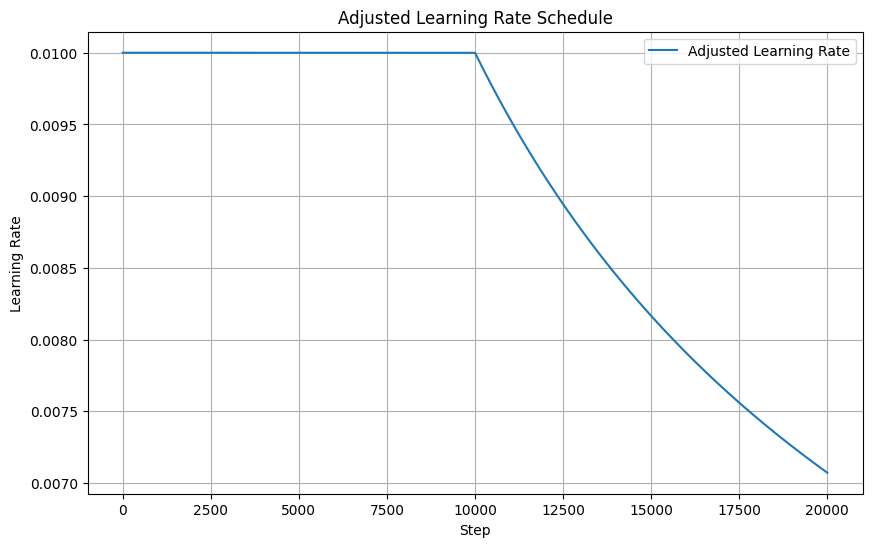

In [27]:
# Let us plot the Learning Rates

import numpy as np
import matplotlib.pyplot as plt

class AdjustedScheduledOptim:
    def __init__(self, n_warmup_steps):
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0

    def calculate_lr(self):
        step = self.n_current_steps + 1
        warmup = self.n_warmup_steps

        if step <= warmup:
            lr = 0.01
        else:
            lr = 1 / np.sqrt(max(step, warmup))

        self.n_current_steps += 1
        return lr


n_warmup_steps = 10000
n_steps = 20000

adjusted_scheduled_optim = AdjustedScheduledOptim(n_warmup_steps=n_warmup_steps)

# Calculate the learning rates
adjusted_lrs = [adjusted_scheduled_optim.calculate_lr() for _ in range(n_steps)]

# Plotting the adjusted learning rates
plt.figure(figsize=(10, 6))
plt.plot(adjusted_lrs, label='Adjusted Learning Rate')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Adjusted Learning Rate Schedule')
plt.grid(True)
plt.legend()
plt.show()


#### AdaFactor

In [21]:
#import math
#import torch
#from typing import Any, Dict, Tuple
#from torch.optim.optimizer import Optimizer
#from types import OptFloat, OptLossClosure, Params, State


Params = Union[Iterable[Tensor], Iterable[Dict[str, Any]]]
LossClosure = Callable[[], float]
OptLossClosure = Optional[LossClosure]
Betas2 = Tuple[float, float]
State = Dict[str, Any]
OptFloat = Optional[float]
Nus2 = Tuple[float, float]

Eps2 = Tuple[float, float]
ParamGroup = Dict[str, Any]

class Adafactor(Optimizer):
    """Implements Adafactor algorithm.

    It has been proposed in: `Adafactor: Adaptive Learning Rates with
    Sublinear Memory Cost`__.

    Arguments:
        params: iterable of parameters to optimize or dicts defining
            parameter groups
        lr: external learning rate (default: None)
        eps2: regularization constans for square gradient
            and parameter scale respectively (default: (1e-30, 1e-3))
        clip_threshold: threshold of root mean square of
            final gradient update (default: 1.0)
        decay_rate: coefficient used to compute running averages of square
            gradient (default: -0.8)
        beta1: coefficient used for computing running averages of gradient
            (default: None)
        weight_decay: weight decay (L2 penalty) (default: 0)
        scale_parameter: if true, learning rate is scaled by root mean square
            of parameter (default: True)
        relative_step: if true, time-dependent learning rate is computed
            instead of external learning rate (default: True)
        warmup_init: time-dependent learning rate computation depends on
            whether warm-up initialization is being used (default: False)

    Example:
        >>> import torch_optimizer as optim
        >>> optimizer = optim.Adafactor(model.parameters())
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()

    __ https://arxiv.org/abs/1804.04235

    Note:
        Reference code: https://github.com/pytorch/fairseq/blob/master/fairseq/optim/adafactor.py  # noqa
        https://github.com/jettify/pytorch-optimizer/blob/master/torch_optimizer/adafactor.py
    """

    def __init__(
        self,
        params: Params,
        lr: OptFloat = None,
        eps2: Eps2 = (1e-30, 1e-3),
        clip_threshold: float = 1.0,
        decay_rate: float = -0.8,
        beta1: OptFloat = None,
        weight_decay: float = 0.0,
        scale_parameter: bool = True,
        relative_step: bool = True,
        warmup_init: bool = False,
    ):
        if lr is not None and lr <= 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if weight_decay < 0.0:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay)
            )

        defaults = dict(
            lr=lr,
            eps2=eps2,
            clip_threshold=clip_threshold,
            decay_rate=decay_rate,
            beta1=beta1,
            weight_decay=weight_decay,
            scale_parameter=scale_parameter,
            relative_step=relative_step,
            warmup_init=warmup_init,
        )
        super(Adafactor, self).__init__(params, defaults)

    def _get_lr(self, param_group: ParamGroup, param_state: State) -> float:
        rel_step_sz = param_group["lr"]
        if param_group["relative_step"]:
            min_step = (
                1e-6 * param_state["step"]
                if param_group["warmup_init"]
                else 1e-2
            )
            rel_step_sz = min(min_step, 1.0 / param_state["step"]**-0.5)
        param_scale = 1.0
        if param_group["scale_parameter"]:
            param_scale = max(param_group["eps2"][1], param_state["RMS"])
        return param_scale * rel_step_sz

    def _get_options(
        self, param_group: ParamGroup, param_shape: Tuple[int, ...]
    ) -> Tuple[bool, bool]:
        factored = len(param_shape) >= 2
        use_first_moment = param_group["beta1"] is not None
        return factored, use_first_moment

    def _rms(self, tensor: torch.Tensor) -> float:
        return tensor.norm(2) / (tensor.numel() ** 0.5)

    def _approx_sq_grad(
        self,
        exp_avg_sq_row: torch.Tensor,
        exp_avg_sq_col: torch.Tensor,
        output: torch.Tensor,
    ) -> None:
        r_factor = (
            (exp_avg_sq_row / exp_avg_sq_row.mean(dim=-1))
            .rsqrt_()
            .unsqueeze(-1)
        )
        c_factor = exp_avg_sq_col.unsqueeze(-2).rsqrt()
        torch.mul(r_factor, c_factor, out=output)

    def step(self, closure: OptLossClosure = None) -> OptFloat:
        r"""Performs a single optimization step.

        Arguments:
            closure: A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        "Adafactor does not support sparse gradients."
                    )

                state = self.state[p]
                grad_shape = grad.shape

                factored, use_first_moment = self._get_options(
                    group, grad_shape
                )
                # State Initialization
                if len(state) == 0:
                    state["step"] = 0

                    if use_first_moment:
                        # Exponential moving average of gradient values
                        state["exp_avg"] = torch.zeros_like(
                            grad, memory_format=torch.preserve_format
                        )
                    if factored:
                        state["exp_avg_sq_row"] = torch.zeros(
                            grad_shape[:-1]
                        ).type_as(grad)
                        state["exp_avg_sq_col"] = torch.zeros(
                            grad_shape[:-2] + grad_shape[-1:]
                        ).type_as(grad)
                    else:
                        state["exp_avg_sq"] = torch.zeros_like(
                            grad, memory_format=torch.preserve_format
                        )

                    state["RMS"] = 0

                state["step"] += 1
                state["RMS"] = self._rms(p.data)
                lr = self._get_lr(group, state)

                beta2t = 1.0 - math.pow(state["step"], group["decay_rate"])
                update = (grad**2) + group["eps2"][0]
                if factored:
                    exp_avg_sq_row = state["exp_avg_sq_row"]
                    exp_avg_sq_col = state["exp_avg_sq_col"]

                    exp_avg_sq_row.mul_(beta2t).add_(
                        update.mean(dim=-1), alpha=1.0 - beta2t
                    )
                    exp_avg_sq_col.mul_(beta2t).add_(
                        update.mean(dim=-2), alpha=1.0 - beta2t
                    )

                    # Approximation of exponential moving average of square
                    # of gradient
                    self._approx_sq_grad(
                        exp_avg_sq_row, exp_avg_sq_col, update
                    )
                    update.mul_(grad)
                else:
                    exp_avg_sq = state["exp_avg_sq"]

                    exp_avg_sq.mul_(beta2t).add_(update, alpha=1.0 - beta2t)
                    torch.rsqrt(exp_avg_sq, out=update).mul_(grad)

                update.div_(
                    max(1.0, self._rms(update) / group["clip_threshold"])
                )
                update.mul_(lr)

                if use_first_moment:
                    exp_avg = state["exp_avg"]
                    exp_avg.mul_(group["beta1"]).add_(
                        update, alpha=1 - group["beta1"]
                    )
                    update = exp_avg

                if group["weight_decay"] != 0:
                    p.data.add_(p.data, alpha=-group["weight_decay"] * lr)

                p.data.add_(-update)

        return loss

### Training class

In [23]:
#from typing import Tuple, List, Union
#import torch
#import torch.nn as nn
#from torch.utils.data import DataLoader
#from scheduled_optim import ScheduledOptim
#from config import Config
#from t5_model import T5Model

class T5Trainer:
    """
    A trainer class for T5Model, designed to encapsulate the training and testing routines. It manages the training epochs,
    data loading, model optimization, and evaluation, providing a streamlined workflow for experimenting with the T5Model.
    The trainer supports both training and testing phases, handling the forward pass, loss computation, gradient backpropagation,
    and parameter updates.

    Attributes:
        model (T5Model): The T5Model instance to be trained and evaluated.
        log_freq (int): Frequency of logging training progress (number of iterations).
        batch_size (int): The size of input data batches for training and testing.
        save_path (str): Path where the trained model checkpoints will be saved.
        device (torch.device): The device (CPU/GPU) on which the model and data should be loaded.
        train_data (DataLoader): DataLoader instance providing access to the training data.
        test_data (DataLoader, optional): DataLoader instance providing access to the test data. Default is None.
        optim (ScheduledOptim): The optimizer with a learning rate scheduling mechanism used for training.
        criterion (nn.NLLLoss): The loss function used for model training.

    Args:
        config (Config): Configuration object containing model, training, and optimization settings.
        t5 (T5Model): The T5Model instance to be trained and evaluated.
        optim (ScheduledOptim): The optimizer with a learning rate scheduling mechanism used for training.
        device (torch.device): The device (CPU/GPU) on which the model and data should be loaded.
        train_dataloader (DataLoader): DataLoader instance providing access to the training data.
        test_dataloader (DataLoader, optional): DataLoader instance providing access to the test data. Default is None.
    """

    def __init__(self, config: Config, t5: T5Model, optim: ScheduledOptim, device: torch.device,
                 train_dataloader: DataLoader, test_dataloader: DataLoader = None):
        self.model = t5
        self.log_freq: int = config.log_freq
        self.batch_size: int = config.batch_size
        self.save_path: str = config.save_path
        self.device = device
        # Setting the train and test data loader
        self.train_data: DataLoader = train_dataloader
        self.test_data: DataLoader = test_dataloader
        self.optim: ScheduledOptim = optim

        # Using Negative Log Likelihood Loss function
        self.criterion: nn.NLLLoss = nn.NLLLoss(ignore_index=-100)


        print("Total Parameters:", sum(p.nelement() for p in self.model.parameters()))

    def train(self, epoch: int) -> None:
        """
        Train the T5Model for one epoch.

        Args:
            epoch (int): Current epoch number.
        """
        self.model.train()
        self.iteration(epoch, self.train_data, train=True)

    def test(self, epoch: int) -> None:
        """
        Evaluates the T5Model on the test dataset, if provided.

        Args:
            epoch (int): Current epoch number.
        """
        self.model.eval()
        with torch.no_grad():
            self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch: int, data_iter: DataLoader, train: bool = True) -> None:
        """
        Perform an iteration of training or testing.

        Args:
            epoch (int): Current epoch number.
            data_iter (DataLoader): DataLoader for the data.
            train (bool): Whether to train the model (True) or test (False).
        """
        str_code: str = "train" if train else "test"
        avg_loss: float = 0.0
        i: int = 0

        print("Number of batches in DataLoader:", len(data_iter))

        for batch in data_iter:

            batch = {key: value.to(self.device) for key, value in batch.items()}

            encoder_ids = batch['encoder_ids']
            decoder_ids = batch['decoder_ids']
            labels = batch['labels']
            mask = batch['attention_mask']

            lm_output = self.model.forward(encoder_ids, decoder_ids, mask)

            loss = self.criterion(lm_output.transpose(1, 2), labels)

            if train:
                self.optim.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optim.step_and_update_lr()

            avg_loss += loss.item()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                output_str = "Epoch: {}, Iteration: {}, Avg Loss: {:.4f}, Current Loss: {:.4f}".format(
                    post_fix['epoch'], post_fix['iter'], post_fix['avg_loss'], post_fix['loss']
                )
                print(output_str)

            i += 1

        print("Epoch %d, %s, avg_loss=" % (epoch, str_code), avg_loss / len(data_iter))


    def save(self, epoch: int) -> str:
        """
        """
        output_path: str = self.save_path + ".ep%d" % epoch

        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.cpu().state_dict(),
            'optimizer_state_dict': self.optim.state_dict(),
        }, output_path)

        self.model.to(self.device)

        print("Epoch %d Model and Optimizer State Saved on:" % epoch, output_path)
        return output_path

### Monitor

In [24]:
#import torch
#import argparse
#import numpy as np
#import random as rd
#from trainer import T5Trainer
#from adafactor import AdaFactor
#from dataset import CustomTextDataset
#from torch.utils.data import DataLoader
#from scheduled_optim import ScheduledOptim


def set_seeds(config):
    """
    Sets the seed for random number generators in Python's `random` module, NumPy, and PyTorch to ensure reproducible results.
    If CUDA is available and specified in the configuration, it also sets the seed for CUDA's random number generator and
    makes CUDA's operations deterministic.

    This function is crucial for experiments where reproducibility is important, as it ensures that the model initialization,
    data shuffling, and other operations that rely on random number generation can be replicated exactly.

    Args:
        config (Config): A configuration object containing at least a `seed` attribute and a `with_cuda` boolean indicating
                         whether CUDA-specific seeds need to be set for reproducibility.
    """
    rd.seed(config.seed)
    np.random.seed(config.seed)
    torch.manual_seed(config.seed)

    if torch.cuda.is_available() and config.with_cuda:
        torch.cuda.manual_seed_all(config.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def run(config):
    """
    The main function that sets up the environment, loads the dataset, initializes the T5 model along with its optimizer and
    scheduler, and then runs the training and testing loops according to the provided configuration.

    This function serves as the entry point for training the T5 model, orchestrating the process from dataset preparation
    to model training and evaluation. It leverages the `T5Trainer` class to abstract away the complexities of the training
    and testing loops.

    Args:
        config (Config): A configuration object containing all necessary parameters to initialize datasets, the model,
                         optimizer, scheduler, and other components of the training process. This includes dataset paths,
                         model hyperparameters, training options, device configuration, etc.

    Note:
        This function is designed to be called directly from the command line or as part of a script. It reads the configuration,
        prepares the datasets, sets the computational device, initializes the model and its components, and finally starts the
        training process followed by testing, if a test dataset is provided.
    """
    # Set random seeds
    set_seeds(config)

    print("Loading Train Dataset...")

    # Load training dataset
    train_dataset = CustomTextDataset(config.data_dir, tokenizer= config.tokenizer_path, max_token_len = config.max_token_len)

    if config.test_dataset is not None:
        print("Loading Test Dataset...")
    # Load test dataset if provided
    test_dataset = CustomTextDataset(config.data_dir, tokenizer= config.tokenizer_path, max_token_len = config.max_token_len) if config.test_dataset is not None else None

    # Setup cuda device for T5 training
    cuda_condition: bool = torch.cuda.is_available() and config.with_cuda
    device: torch.device = torch.device("cuda:0" if cuda_condition else "cpu")

    # Initialize T5Model
    t5 = T5Model(config).to(device)

    # Distributed GPU training if CUDA can detect more than 1 GPU
    if config.with_cuda and torch.cuda.device_count() > 1:
        print("Using %d GPUs for T5Model" % torch.cuda.device_count())
        t5: nn.DataParallel = nn.DataParallel(t5, device_ids=config.cuda_devices)

    # Initialize optimizer and scheduler
    """To use a manual (external) learning rate schedule you should set scale_parameter=False and relative_step=False.
      In T5 case, additional optimizer operations like gradient clipping should not be used alongside Adafactor. We also set warmup_init to False.
      # https://discuss.huggingface.co/t/t5-finetuning-tips/684
    """
    optim = Adafactor(t5.parameters(), scale_parameter=False, relative_step=False, warmup_init=False, lr=None)
    optim_schedule = ScheduledOptim(optim, config.hidden_size, config.n_warmup_steps)

    # Create data loaders
    batch_size = config.batch_size
    train_data_loader = DataLoader(train_dataset, batch_size = batch_size, worker_init_fn=np.random.seed(config.seed), shuffle = True)
    test_data_loader = DataLoader(test_dataset, batch_size= batch_size, worker_init_fn=np.random.seed(config.seed)) if test_dataset is not None else None

    # Initialize t5 trainer
    trainer = T5Trainer(config, t5, optim_schedule, device, train_data_loader, test_data_loader)

    # Training loop
    for epoch in range(config.epochs):
        # Train the model
        trainer.train(epoch)

        # Save the model
        trainer.save(epoch)

        # Test the model if test data is available
        if test_data_loader is not None:
            trainer.test(epoch)

if __name__ == "__main__":
    # Load configuration
    config = Config(
        prop=0.15,
        tokenizer_path='t5-base',
        max_token_len= 768,
        bidirectional= True,
        num_buckets= 32,
        max_distance= 128,
        data_dir= 'dataset/train.txt',
        hidden_size= 128,
        vocab_size= 32000,
        hidden_dropout_prob= 0.1,
        num_heads= 2,
        num_blocks= 2,
        n_warmup_steps= 10000,
        cuda_devices=None,
        with_cuda= True,
        log_freq= 10,
        batch_size= 16,
        save_path= 'tmp',
        seed= 2024,
        test_dataset= None,
        epochs= 2
    )

    run(config)


Loading Train Dataset...
Total Parameters: 4604068
Number of batches in DataLoader: 1413
LR: 0.01
Epoch: 0, Iteration: 0, Avg Loss: 16.9451, Current Loss: 16.9451
LR: 0.01
LR: 0.01
LR: 0.01
LR: 0.01
LR: 0.19764235376052372
LR: 0.1397542485937369
LR: 0.11410886614690961
LR: 0.09882117688026186
LR: 0.08838834764831845
LR: 0.08068715304598786
Epoch: 0, Iteration: 10, Avg Loss: 1406690.7941, Current Loss: 1305294.0000
LR: 0.07470178808339961
LR: 0.06987712429686845
LR: 0.06588078458684124
LR: 0.06250000000000001
LR: 0.05959141182784952
LR: 0.057054433073454806
LR: 0.05481612620668933
LR: 0.05282214092053229
LR: 0.05103103630798289
LR: 0.04941058844013093
Epoch: 0, Iteration: 20, Avg Loss: 1093762.4652, Current Loss: 74864.3359
LR: 0.04793531180296066
LR: 0.046584749531245626
LR: 0.04534226563187573
LR: 0.04419417382415922
LR: 0.04312909745889715
LR: 0.042137491403952634
LR: 0.04121127958723669
LR: 0.04034357652299393
LR: 0.03952847075210475
LR: 0.038760854559127644
Epoch: 0, Iteration: 30,

KeyboardInterrupt: 